# 高斯朴素贝叶斯
## 介绍
本作业主要基于朴素贝叶斯算法对`iris`数据集分类，由于`iris`数据特征是连续的值，所以假定每个特征的值服从正态分布。整个建模的总体思想依照贝叶斯学派；参数估计符合频率派的思想，采用极大似然估计。所以朴素贝叶斯算法是结合了两个流派的特点。贝叶斯模型的公式如下：
$$
P(Y|X) = \cfrac{P(X|Y)P(Y)}{P(X)}
$$
## 作业流程
1. 数据预处理
2. 估计模型参数
3. 预测
4. 计算精度

## 1. 数据预处理
### 1.1 加载数据集
该作业直接从`sklearn`导入`iris`数据集，以7：3的比例划分数据集,并返回训练集与测试集的`dataframe`

In [36]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

features = ['sepal length', 'sepal width', 'petal length', 'petal width']
catagories = ['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica']
catagories_encode = [0, 1, 2]

# Load the iris dataset and return two dataframes which include training set and test set
def load_iris():
    # Load the iris dataset
    iris = datasets.load_iris()
    
    # Divide the training set and test set by 7:3
    x_train, x_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size = 0.3)
    
    # Create a dataframe from the training set
    iris_x_train = pd.DataFrame(x_train, columns=features)
    iris_y_train = pd.DataFrame(y_train, columns=['catagory'])
    iris_train_df = iris_x_train.join(iris_y_train)
    
    # Create a dataframe from the test set
    iris_x_test = pd.DataFrame(x_test, columns=features)
    iris_y_test = pd.DataFrame(y_test, columns=['catagory'])
    iris_test_df = iris_x_test.join(iris_y_test)
    
    return iris_train_df, iris_test_df

### 1.2 查看数据集简略统计信息
使用`pandas`函数描述训练集与测试集的简略统计信息

In [37]:
# Load training set and test set
iris_train_df, iris_test_df = load_iris()
# View a short summary of the data set
print(iris_train_df.describe(), '\n')
print(iris_test_df.describe())

       sepal length  sepal width  petal length  petal width   catagory
count    105.000000   105.000000    105.000000   105.000000  105.00000
mean       5.842857     3.060952      3.757143     1.197143    1.00000
std        0.894842     0.413358      1.811972     0.779356    0.83205
min        4.300000     2.000000      1.100000     0.100000    0.00000
25%        5.100000     2.800000      1.500000     0.300000    0.00000
50%        5.800000     3.000000      4.400000     1.300000    1.00000
75%        6.400000     3.300000      5.100000     1.800000    2.00000
max        7.900000     4.400000      6.900000     2.500000    2.00000 

       sepal length  sepal width  petal length  petal width   catagory
count     45.000000    45.000000     45.000000    45.000000  45.000000
mean       5.844444     3.048889      3.760000     1.204444   1.000000
std        0.655243     0.489258      1.671064     0.729245   0.797724
min        4.600000     2.200000      1.000000     0.200000   0.000000
25% 

## 2.估计模型的参数
### 2.1 估计`Gaussian`分布的期望与方差
在假定$X$服从`Gaussian`分布的情况下，我们只需要估计均值$\mu$与方差$\sigma$。`Gaussian`分布概率密度函数如下：
$$
f(x) = \cfrac{1}{\sigma\sqrt{2\pi}}\exp(-\cfrac{(x-\mu)^2}{\sigma^2})
$$
设有m个样本$(x_1,x_2,\ldots, x_m)$，按照极大似然估计计算参数。
\begin{align}
L(\mu, \sigma) = & \prod_{i=1}^{m} {f(x_i)}\\
\log{L(\mu, \sigma)} = & \sum_{i=1}^{m} \log{f(x_i)}
\end{align}


In [52]:
# Estimate parameters
def estimate_parameters(train_df, target_num):
    parameters = {}
    
    value_counts = train_df['catagory'].value_counts()
    for i in range(target_num):
        # Estimate the mean and unbiased standard deviation of each feature under a specific category
        parameters['mean' + str(i)] = train_df[train_df['catagory'] == i].mean()
        parameters['std' + str(i)] = train_df[train_df['catagory'] == i].std()
        # Estimate category prior
        parameters["catagory_prob" + str(i)] = value_counts[i] / train_df['catagory'].shape[0]
    return parameters

In [42]:
parameters = estimate_parameters(iris_train_df, 3)
print(parameters['mean1'], '\n')
print(parameters['std1'], '\n')
print(parameters['catagory_prob1'])

sepal length    5.945455
sepal width     2.796970
petal length    4.260606
petal width     1.354545
catagory        1.000000
dtype: float64 

sepal length    0.547204
sepal width     0.335862
petal length    0.456850
petal width     0.180435
catagory        0.000000
dtype: float64 

0.3142857142857143


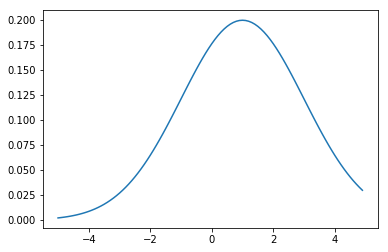

In [43]:
def calculate_gaussian_density(x ,mean, std):
    return stats.norm.pdf(x, loc=mean, scale=std)

# plot the curve of gaussian desity
x = np.arange(-5, 5, 0.1)
plt.plot(x, calculate_gaussian_density(x, 1, 2))
plt.show()

In [44]:
def predict(test_df, paramters, target_num):
    denominator = np.zeros(test_df.shape[0])
    numerators = []
    for i in range(target_num):
        mean = parameters['mean' + str(i)]
        std = parameters['std' + str(i)]
        catagory_prob = parameters['catagory_prob' + str(i)]
            
        densities = 1 
        for feature in features:
            densities = densities * calculate_gaussian_density(test_df[feature], mean[feature], std[feature])
        
        densities = densities * catagory_prob 
        denominator += densities
        numerators.append(densities)
    
    prob = pd.DataFrame(np.array([numerator / denominator for numerator in numerators]).T, columns=catagories_encode)
    catagory_pred = pd.DataFrame(prob.idxmax(axis=1), columns=['catagory_pred'])
    return test_df.join(catagory_pred)

In [50]:
df = predict(iris_test_df, parameters, 3)
df

,sepal length,sepal width,petal length,petal width,catagory,catagory_pred
0,6.8,3.0,5.5,2.1,2,2
1,5.1,3.8,1.9,0.4,0,0
2,6.0,2.7,5.1,1.6,1,1
3,6.9,3.1,5.1,2.3,2,2
4,5.7,3.8,1.7,0.3,0,0
5,5.0,3.4,1.6,0.4,0,0
6,6.5,3.0,5.8,2.2,2,2
7,6.4,2.7,5.3,1.9,2,2
8,6.3,3.3,6.0,2.5,2,2
9,5.1,3.8,1.6,0.2,0,0


In [46]:
def compute_accurary(df):
    accurary = df[df['catagory'] == df['catagory_pred']].shape[0] / df['catagory'].shape[0]
    return accurary

In [48]:
accurary = compute_accurary(df)
print(accurary)

0.9555555555555556
